## Importing Library

In [381]:
import numpy as np 
import pandas as pd 
import nltk
import os
import gc
from nltk.corpus import stopwords
from keras.preprocessing import sequence,text
from sklearn.model_selection import cross_val_score
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth', -1)

In [382]:
gc.collect()

8

### Loading dataset and basic visualization

In [383]:
train=pd.read_csv('train.tsv',sep='\t')
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Sentiment
0    7072 
1    27273
2    79582
3    32927
4    9206 
Name: PhraseId, dtype: int64

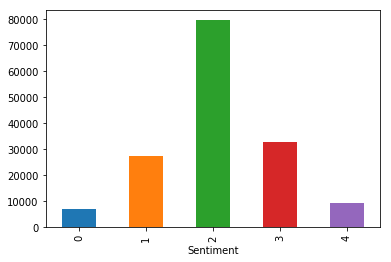

In [384]:
x = train.groupby(['Sentiment'])['PhraseId'].count()
x.plot.bar()
x

The classes as you can observe are imbalanced

We therfore balance the classes:

Sentiment
0    7072
1    7072
2    7072
3    7072
4    7072
Name: PhraseId, dtype: int64

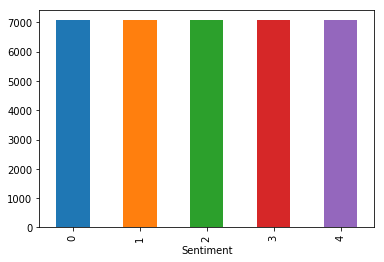

In [385]:
df3 = train.loc[train['Sentiment'] == 0].sample(n=7072)
df6 = train.loc[train['Sentiment'] == 1].sample(n=7072)
df2 = train.loc[train['Sentiment'] == 2].sample(n=7072)
df4 = train.loc[train['Sentiment'] == 3].sample(n=7072)
df5 = train.loc[train['Sentiment'] == 4].sample(n=7072)
train = pd.concat([df2,df3,df4,df5,df6], axis=0)
x = train.groupby(['Sentiment'])['PhraseId'].count()
x.plot.bar()
x

The classes are now balanced.

### Visualizing the word cloud for each class:

In [386]:
from wordcloud import WordCloud, STOPWORDS

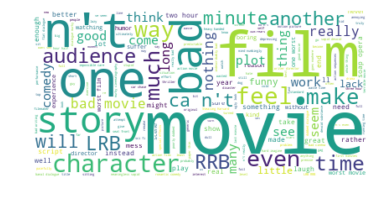

In [387]:
class_0 = " ".join(review for review in df3.Phrase)

# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(class_0)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

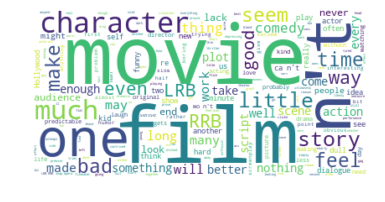

In [388]:
class_1 = " ".join(review for review in df6.Phrase)

# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(class_1)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

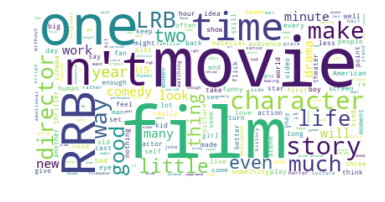

In [389]:
class_2 = " ".join(review for review in df2.Phrase)

# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(class_2)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

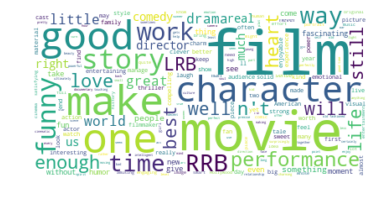

In [390]:
class_3 = " ".join(review for review in df4.Phrase)

# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(class_3)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

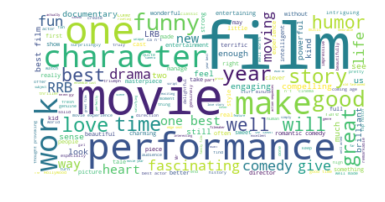

In [391]:
class_4 = " ".join(review for review in df5.Phrase)

# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(class_4)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [392]:
test=pd.read_csv('test.tsv',sep='\t')
print(test.shape)
test.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [393]:
sub=pd.read_csv('sampleSubmission.csv')
sub.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


**Adding Sentiment column to test datset and joing train and test for preprocessing**

In [394]:
test['Sentiment']=-999
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,-999
1,156062,8545,An intermittently pleasing but mostly routine effort,-999
2,156063,8545,An,-999
3,156064,8545,intermittently pleasing but mostly routine effort,-999
4,156065,8545,intermittently pleasing but mostly routine,-999


In [395]:
df=pd.concat([train,test],ignore_index=True)
print(df.shape)
df.tail()

(101652, 4)


,PhraseId,SentenceId,Phrase,Sentiment
101647,222348,11855,"A long-winded , predictable scenario .",-999
101648,222349,11855,"A long-winded , predictable scenario",-999
101649,222350,11855,"A long-winded ,",-999
101650,222351,11855,A long-winded,-999
101651,222352,11855,predictable scenario,-999


In [396]:
del train,test
gc.collect()

15725

We clean up the reviews

In [397]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re


In [398]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [399]:
df['clean_review']=clean_review(df.Phrase.values)
df.head()


,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,136955,7408,work as a piece of storytelling,2,work a a piece of storytelling
1,121688,6521,solipsistic,2,solipsistic
2,33846,1590,The kind of sense of humor that derives from a workman 's grasp of pun and entendre and its attendant need to constantly draw attention to itself .,2,the kind of sense of humor that derives from a workman s grasp of pun and entendre and it attendant need to constantly draw attention to itself
3,111957,5942,overpowered,2,overpowered
4,55695,2785,of horror and sci-fi,2,of horror and sci fi


Separate the train and test sets

In [400]:
df_train=df[df.Sentiment!=-999]
df_train.shape

(35360, 5)

In [401]:
df_test=df[df.Sentiment==-999]
df_test.drop('Sentiment',axis=1,inplace=True)
print(df_test.shape)
df_test.head()

(66292, 4)


,PhraseId,SentenceId,Phrase,clean_review
35360,156061,8545,An intermittently pleasing but mostly routine effort .,an intermittently pleasing but mostly routine effort
35361,156062,8545,An intermittently pleasing but mostly routine effort,an intermittently pleasing but mostly routine effort
35362,156063,8545,An,an
35363,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing but mostly routine effort
35364,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing but mostly routine


In [402]:
del df
gc.collect()

0

### Splitting Train dataset into train and 20% validation set

In [403]:
train_text=df_train.clean_review.values
test_text=df_test.clean_review.values
target=df_train.Sentiment.values
y=to_categorical(target)
print(train_text.shape,target.shape,y.shape)

(35360,) (35360,) (35360, 5)


In [404]:
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(28288,) (28288, 5)
(7072,) (7072, 5)


### Finding number of unique words in train set

In [405]:
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

12211

### Finding max length of a review in train set

In [406]:
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

48

## Visualizing the Data Distribution

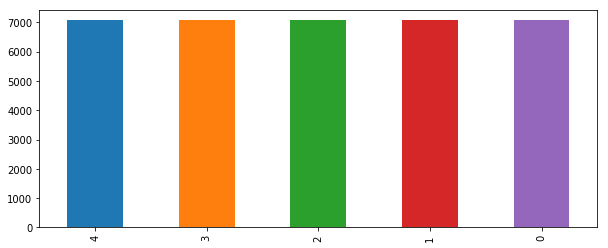

In [407]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

    
df_encoded = df_train
df_encoded = MultiColumnLabelEncoder(columns = ['Sentiment']).fit_transform(df_encoded)
labels = ['0','1','2','3','4']
plt.figure(figsize=(10,4))

df_encoded.Sentiment.value_counts().plot(kind='bar');

## Preprocessing for ML Classification

In [408]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords)
STOPWORDS.update(["one","film","movie"])

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    #text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df_encoded['Phrase'] = df_encoded['Phrase'].apply(clean_text)
df_encoded['Phrase'].apply(lambda x: len(x.split(' '))).sum()


171156

In [409]:
from sklearn.utils import shuffle
shuffle(df_encoded)

X = df_encoded.Phrase
y = df_encoded.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## Classifying using a TfIDf Transformer

### Using a Multinomial Naive Bayes Classifier

In [410]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

#%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=labels))

accuracy 0.46370663650075417
              precision    recall  f1-score   support

           0       0.52      0.69      0.59      2122
           1       0.42      0.35      0.38      2185
           2       0.44      0.23      0.30      2127
           3       0.40      0.33      0.36      2120
           4       0.48      0.74      0.58      2054

   micro avg       0.46      0.46      0.46     10608
   macro avg       0.45      0.47      0.44     10608
weighted avg       0.45      0.46      0.44     10608



### Using a Random Forest Classifier

In [411]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=20)),
               ])
rf.fit(X_train, y_train)

#%%time

y_pred = rf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=labels))

accuracy 0.5314856711915535
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      2122
           1       0.46      0.38      0.42      2185
           2       0.47      0.66      0.55      2127
           3       0.41      0.33      0.37      2120
           4       0.65      0.65      0.65      2054

   micro avg       0.53      0.53      0.53     10608
   macro avg       0.53      0.53      0.53     10608
weighted avg       0.53      0.53      0.53     10608



## Using a Word2Vec Model with Google News Vectors

In [412]:
import gensim
import logging
from itertools import islice
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)


In [413]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [414]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df_encoded, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['Phrase']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['Phrase']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)


### Using a Logistic Regression Classifier

In [415]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['Sentiment'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.Sentiment))
print(classification_report(test.Sentiment, y_pred,target_names=labels))

accuracy 0.5239441930618401
              precision    recall  f1-score   support

           0       0.56      0.67      0.61      2122
           1       0.45      0.32      0.37      2185
           2       0.54      0.63      0.58      2127
           3       0.42      0.30      0.35      2120
           4       0.58      0.72      0.64      2054

   micro avg       0.52      0.52      0.52     10608
   macro avg       0.51      0.53      0.51     10608
weighted avg       0.51      0.52      0.51     10608



### Using a Random Forest Classifier

In [416]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf = rf.fit(X_train_word_average, train['Sentiment'])
y_pred = rf.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.Sentiment))
print(classification_report(test.Sentiment, y_pred,target_names=labels))

accuracy 0.4671945701357466
              precision    recall  f1-score   support

           0       0.53      0.61      0.57      2122
           1       0.38      0.37      0.37      2185
           2       0.46      0.48      0.47      2127
           3       0.37      0.31      0.34      2120
           4       0.59      0.56      0.58      2054

   micro avg       0.47      0.47      0.47     10608
   macro avg       0.46      0.47      0.47     10608
weighted avg       0.46      0.47      0.46     10608



## Doc2Vec approaches at a document level

In [417]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

stemmer = PorterStemmer()
words = stopwords.words("english")
df_encoded['Phrase'] = df_encoded['Phrase'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

X_train, X_test, y_train, y_test = train_test_split(df_encoded.Phrase, df_encoded.Sentiment, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [418]:
all_data[:2]

[TaggedDocument(words=['urgent', 'question'], tags=['Train_0']),
 TaggedDocument(words=['feel', 'trip', 'great', 'deal', 'fun'], tags=['Train_1'])]

In [419]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 35360/35360 [00:00<00:00, 2631720.16it/s]


In [376]:
 def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

### Using a Logistic Regression Classifier

In [377]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=labels))

accuracy 0.4549396681749623
              precision    recall  f1-score   support

           0       0.52      0.60      0.56      2103
           1       0.35      0.23      0.27      2143
           2       0.41      0.57      0.48      2102
           3       0.37      0.25      0.30      2112
           4       0.55      0.63      0.59      2148

   micro avg       0.45      0.45      0.45     10608
   macro avg       0.44      0.46      0.44     10608
weighted avg       0.44      0.45      0.44     10608



### Using a Random Forest Classifier

In [378]:
rf = RandomForestClassifier()
rf.fit(train_vectors_dbow, y_train)
rf = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=labels))

accuracy 0.4549396681749623
              precision    recall  f1-score   support

           0       0.52      0.60      0.56      2103
           1       0.35      0.23      0.27      2143
           2       0.41      0.57      0.48      2102
           3       0.37      0.25      0.30      2112
           4       0.55      0.63      0.59      2148

   micro avg       0.45      0.45      0.45     10608
   macro avg       0.44      0.46      0.44     10608
weighted avg       0.44      0.45      0.44     10608



## Building more Keras models

In [452]:
train=pd.read_csv('train.tsv',sep='\t')
test=pd.read_csv('test.tsv',sep='\t')
sub=pd.read_csv('sampleSubmission.csv')
test['Sentiment']=-999
df=pd.concat([train,test],ignore_index=True)
del train,test
gc.collect()


32

In [453]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re

In [454]:
df['clean_review']=clean_review(df.Phrase.values)
df_train=df[df.Sentiment!=-999]
df_test=df[df.Sentiment==-999]
df_test.drop('Sentiment',axis=1,inplace=True)
del df
gc.collect()
train_text=df_train.clean_review.values
test_text=df_test.clean_review.values
target=df_train.Sentiment.values
y=to_categorical(target)
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=1)



In [455]:
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)

In [456]:
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

48

In [457]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 128
epochs = 10
num_classes=5

In [458]:
#Tokenization
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(test_text)

In [459]:
# Pad the data
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


### LSTM model

In [205]:
model1=Sequential()
model1.add(Embedding(max_features,100,mask_zero=True))
model1.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model1.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model1.add(Dense(num_classes,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model1.summary()
cp=ModelCheckpoint('LSTM.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         1374000   
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 64)          42240     
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_68 (Dense)             (None, 5)                 165       
Total params: 1,428,821
Trainable params: 1,428,821
Non-trainable params: 0
_________________________________________________________________


In [206]:
%%time
history1=model1.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=512, verbose=1, callbacks=[cp])

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 126s 1ms/step - loss: 1.2559 - acc: 0.5272 - val_loss: 1.0296 - val_acc: 0.5954

Epoch 00001: val_acc improved from -inf to 0.59541, saving model to LSTM.hdf5
Epoch 2/10
124848/124848 [==============================] - 120s 965us/step - loss: 0.9193 - acc: 0.6293 - val_loss: 0.8699 - val_acc: 0.6483

Epoch 00002: val_acc improved from 0.59541 to 0.64831, saving model to LSTM.hdf5
Epoch 3/10
124848/124848 [==============================] - 121s 968us/step - loss: 0.8134 - acc: 0.6678 - val_loss: 0.8457 - val_acc: 0.6534

Epoch 00003: val_acc improved from 0.64831 to 0.65340, saving model to LSTM.hdf5
Epoch 4/10
124848/124848 [==============================] - 123s 988us/step - loss: 0.7692 - acc: 0.6836 - val_loss: 0.8434 - val_acc: 0.6550

Epoch 00004: val_acc improved from 0.65340 to 0.65497, saving model to LSTM.hdf5
Epoch 5/10
124848/124848 [==============================] 

In [207]:
y_pred1=model1.predict_classes(X_test,verbose=1)

66292/66292 [==============================] - 49s 739us/step


In [208]:
sub.Sentiment=y_pred1
sub.to_csv('sub1.csv',index=False)
sub.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


### CNN model

In [219]:
model2= Sequential()
model2.add(Embedding(max_features,100,input_length=max_words))
model2.add(Dropout(0.2))

model2.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
model2.add(GlobalMaxPooling1D())

model2.add(Dense(128,activation='relu'))
model2.add(Dropout(0.2))

model2.add(Dense(num_classes,activation='softmax'))


model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

model2.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 48, 100)           1374000   
_________________________________________________________________
dropout_33 (Dropout)         (None, 48, 100)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 48, 64)            19264     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 5)               

In [220]:
%%time
history2=model2.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[cp])

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 50s 403us/step - loss: 0.9996 - acc: 0.5993 - val_loss: 0.8710 - val_acc: 0.6479

Epoch 00001: val_acc improved from -inf to 0.64789, saving model to model_cnn_lstm_128_long.hdf5
Epoch 2/10
124848/124848 [==============================] - 47s 376us/step - loss: 0.7840 - acc: 0.6773 - val_loss: 0.8084 - val_acc: 0.6666

Epoch 00002: val_acc improved from 0.64789 to 0.66657, saving model to model_cnn_lstm_128_long.hdf5
Epoch 3/10
124848/124848 [==============================] - 48s 385us/step - loss: 0.7032 - acc: 0.7072 - val_loss: 0.8039 - val_acc: 0.6617

Epoch 00003: val_acc did not improve from 0.66657
Epoch 4/10
124848/124848 [==============================] - 51s 409us/step - loss: 0.6487 - acc: 0.7291 - val_loss: 0.8054 - val_acc: 0.6685

Epoch 00004: val_acc improved from 0.66657 to 0.66846, saving model to model_cnn_lstm_128_long.hdf5
Epoch 5/10
124848/124848 [========

In [221]:
y_pred2=model2.predict_classes(X_test, verbose=1)

66292/66292 [==============================] - 7s 105us/step


In [222]:
sub.Sentiment=y_pred2
sub.to_csv('sub2.csv',index=False)
sub.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


## CNN +GRU model

In [223]:
model3= Sequential()
model3.add(Embedding(max_features,100,input_length=max_words))
model3.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(0.25))
model3.add(GRU(128,return_sequences=True))
model3.add(Dropout(0.3))
model3.add(Flatten())
model3.add(Dense(128,activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(5,activation='softmax'))
model3.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
cp=ModelCheckpoint('model_cnn_gru.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
model3.summary()


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 48, 100)           1374000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 48, 64)            19264     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 24, 64)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 128)           74112     
_________________________________________________________________
dropout_36 (Dropout)         (None, 24, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)            

In [224]:
%%time
history3=model3.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[cp])

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 116s 930us/step - loss: 1.0542 - acc: 0.5804 - val_loss: 0.8732 - val_acc: 0.6415

Epoch 00001: val_acc improved from -inf to 0.64148, saving model to model_cnn_gru.hdf5
Epoch 2/10
124848/124848 [==============================] - 107s 859us/step - loss: 0.8199 - acc: 0.6654 - val_loss: 0.8247 - val_acc: 0.6584

Epoch 00002: val_acc improved from 0.64148 to 0.65837, saving model to model_cnn_gru.hdf5
Epoch 3/10
124848/124848 [==============================] - 110s 883us/step - loss: 0.7350 - acc: 0.6956 - val_loss: 0.8104 - val_acc: 0.6708

Epoch 00003: val_acc improved from 0.65837 to 0.67080, saving model to model_cnn_gru.hdf5
Epoch 4/10
124848/124848 [==============================] - 113s 903us/step - loss: 0.6781 - acc: 0.7149 - val_loss: 0.8182 - val_acc: 0.6648

Epoch 00004: val_acc did not improve from 0.67080
Epoch 5/10
124848/124848 [==============================] - 

In [225]:
y_pred3=model3.predict_classes(X_test, verbose=1)


66292/66292 [==============================] - 21s 324us/step


In [226]:
sub.Sentiment=y_pred3
sub.to_csv('sub3.csv',index=False)
sub.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,2
4,156065,3


## 4. Bidirectional GRU

In [227]:
model4 = Sequential()

model4.add(Embedding(max_features, 100, input_length=max_words))
model4.add(SpatialDropout1D(0.25))
model4.add(Bidirectional(GRU(128)))
model4.add(Dropout(0.5))

model4.add(Dense(5, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cp=ModelCheckpoint('BiGRU.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

model4.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 48, 100)           1374000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 48, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               175872    
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 5)                 1285      
Total params: 1,551,157
Trainable params: 1,551,157
Non-trainable params: 0
_________________________________________________________________


In [228]:
%%time
history4=model4.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[cp])

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 253s 2ms/step - loss: 1.0064 - acc: 0.5953 - val_loss: 0.8629 - val_acc: 0.6503

Epoch 00001: val_acc improved from -inf to 0.65029, saving model to BiGRU.hdf5
Epoch 2/10
124848/124848 [==============================] - 300s 2ms/step - loss: 0.8012 - acc: 0.6713 - val_loss: 0.8191 - val_acc: 0.6638

Epoch 00002: val_acc improved from 0.65029 to 0.66385, saving model to BiGRU.hdf5
Epoch 3/10
124848/124848 [==============================] - 246s 2ms/step - loss: 0.7320 - acc: 0.6971 - val_loss: 0.8100 - val_acc: 0.6654

Epoch 00003: val_acc improved from 0.66385 to 0.66545, saving model to BiGRU.hdf5
Epoch 4/10
124848/124848 [==============================] - 246s 2ms/step - loss: 0.6893 - acc: 0.7133 - val_loss: 0.8194 - val_acc: 0.6686

Epoch 00004: val_acc improved from 0.66545 to 0.66862, saving model to BiGRU.hdf5
Epoch 5/10
124848/124848 [==============================] - 

In [229]:
y_pred4=model4.predict_classes(X_test, verbose=1)

66292/66292 [==============================] - 44s 660us/step


In [230]:
sub.Sentiment=y_pred4
sub.to_csv('sub4.csv',index=False)
sub.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,3
4,156065,3


## 5. Glove word embedding

In [460]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')
    
def get_embed_mat(EMBEDDING_FILE, max_features,embed_dim):
    # word vectors
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf8'))
    print('Found %s word vectors.' % len(embeddings_index))

    # embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index) + 1)
    all_embs = np.stack(embeddings_index.values()) #for random init
    embedding_matrix = np.random.normal(all_embs.mean(), all_embs.std(), 
                                        (num_words, embed_dim))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    max_features = embedding_matrix.shape[0]
    
    return embedding_matrix

In [461]:
# embedding matrix
EMBEDDING_FILE = 'glove.6B.100d.txt'
embed_dim = 100 #word vector dim
embedding_matrix = get_embed_mat(EMBEDDING_FILE,max_features,embed_dim)
print(embedding_matrix.shape)

Found 400000 word vectors.
(13740, 100)


In [462]:
model5 = Sequential()
model5.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1],weights=[embedding_matrix],trainable=True))
model5.add(SpatialDropout1D(0.25))
model5.add(Bidirectional(GRU(128,return_sequences=True)))
model5.add(Bidirectional(GRU(64,return_sequences=False)))
model5.add(Dropout(0.5))
model5.add(Dense(num_classes, activation='softmax'))
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cp=ModelCheckpoint('model_glove_embeddings.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
model5.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 48, 100)           1374000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 48, 100)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 48, 256)           175872    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               123264    
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 5)                 645       
Total params: 1,673,781
Trainable params: 1,673,781
Non-trainable params: 0
___________________________________________

In [463]:
%%time
history5=model5.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=10, batch_size=batch_size, verbose=1, callbacks=[cp])

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 438s 4ms/step - loss: 0.9909 - acc: 0.5935 - val_loss: 0.8464 - val_acc: 0.6491

Epoch 00001: val_acc improved from -inf to 0.64914, saving model to model_glove_embeddings.hdf5
Epoch 2/10
124848/124848 [==============================] - 447s 4ms/step - loss: 0.8449 - acc: 0.6504 - val_loss: 0.8023 - val_acc: 0.6640

Epoch 00002: val_acc improved from 0.64914 to 0.66404, saving model to model_glove_embeddings.hdf5
Epoch 3/10
124848/124848 [==============================] - 495s 4ms/step - loss: 0.7836 - acc: 0.6758 - val_loss: 0.7720 - val_acc: 0.6787

Epoch 00003: val_acc improved from 0.66404 to 0.67868, saving model to model_glove_embeddings.hdf5
Epoch 4/10
124848/124848 [==============================] - 650s 5ms/step - loss: 0.7427 - acc: 0.6921 - val_loss: 0.7649 - val_acc: 0.6834

Epoch 00004: val_acc improved from 0.67868 to 0.68342, saving model to model_glove_embeddin

In [464]:
y_pred5=model5.predict_classes(X_test, verbose=1)

66292/66292 [==============================] - 82s 1ms/step


In [465]:
sub.Sentiment=y_pred5
sub.to_csv('sub5.csv',index=False)
sub.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,3
